In [1]:
# # IMPORTS
# astronomy
from astropy.io import fits
# plotting 
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.pyplot as plt
import matplotlib as mpl
# data 
import numpy as np
# file IO
import csv
# my python files 
import match
import v2_AGN_DataAndPlotting as adp
import v2_SED as SED

# Read Data

In [2]:
# open COSMOS 2020 catalog file and get data 
with fits.open(adp.path_cat+'\\COSMOS2020_CLASSIC_R1_v2.0_master.fits') as hdul20:
    data20 = hdul20[1].data
    cols20 = hdul20[1].columns

In [3]:
# get IRAC data (unit = 'uJy')
ch1_data20  = np.array(data20['SPLASH_CH1_FLUX']) # 3.5686 um
print('.', end='')
ch2_data20  = np.array(data20['SPLASH_CH2_FLUX']) # 4.5067 um
print('.', end='')
ch3_data20  = np.array(data20['SPLASH_CH3_FLUX']) # 5.7788 um
print('.', end='')
ch4_data20  = np.array(data20['SPLASH_CH4_FLUX']) # 7.9958 um 
print('.', end='')
# get ID
id_data20 = np.array(data20['ID_COSMOS2015'])
print('.', end='')

.....

In [4]:
# open COSMOS 2016 catalog file and get data 
with fits.open(adp.path_cat+'\\chandra_COSMOS_legacy_opt_NIR_counterparts_20160113_4d.fits') as hdul16:
    data16 = hdul16[1].data
    cols16 = hdul16[1].columns

In [5]:
# get data arrays from columns
id_data16 = np.array(data16['id_k_uv'])
print('.', end='')
L0510_data16 = np.array(data16['Lx_0510']) # x-ray luminosity in the 0.5-10 KeV band
print('.', end='')
k0510_data16 = np.array(data16['abs_corr_0510'])  # absorbtion correction coefficient in the 0.5-10 KeV band
print('.', end='')

...

In [6]:
# returns array of ( min <= z < max )
def GetRedshiftsInRange(
        zDict,   # dictionary of ID and z  
        min=0,   # minimum
        max=99,  # maximum 
        incusiveMin=False,
        printLength=True
) : 
    # get mask of indecies that are in redshift range (true)
    if(incusiveMin):
        mask = (zDict['z'] >= min) & (zDict['z'] < max)
    else: 
        mask = (zDict['z'] > min) & (zDict['z'] <= max)
    # idolate ID and z
    inRange = {
        'ID' : zDict['ID'][mask] ,
        'z'  : zDict['z'] [mask]
    }
    if(printLength) : 
        if(incusiveMin): 
            print(min, '<= z < ', max, ': ', len(inRange['ID']))
        else:
             print(min, '< z <= ', max, ': ', len(inRange['ID']))       
    return(inRange)

# get redshifts
zDict_all = adp.ReadRedshifts(file=adp.path_cat+'\COSMOS_z_matches.csv')

zDict_split = {
    '$0 < z \leq 1$'   : GetRedshiftsInRange(zDict_all,          max=1  ),
    '$1 < z \leq 1.5$' : GetRedshiftsInRange(zDict_all, min=1,   max=1.5),
    '$1.5 < z \leq 2$' : GetRedshiftsInRange(zDict_all, min=1.5, max=2  ),
    '$2 < z \leq 3$'   : GetRedshiftsInRange(zDict_all, min=2,   max=3  ),
    '$3 < z \leq 6$'   : GetRedshiftsInRange(zDict_all, min=3           )
}

Cropped:  ['ID', 'z']
Number of redshifts: 485793
0 < z <=  1 :  211361
1 < z <=  1.5 :  95993
1.5 < z <=  2 :  57518
2 < z <=  3 :  66963
3 < z <=  99 :  44466


In [7]:
def GetAGNduoFromFile(file, printInfo=True):
    # read AGN IDs
    agnIDs_file = adp.ReadFile(file)
    # convert agnIDs into a dictionary of numpy arrays 
    agnIDs_dict = { 
        'MIR'  : np.array(agnIDs_file[0], dtype=int), 
        'XRAY' : np.array(agnIDs_file[1], dtype=int) 
        }
    # print info
    if(printInfo) :
        print('Number of MIR AGN:\t',    len(agnIDs_dict['MIR']))
        print('Number of Xray AGN:\t',   len(agnIDs_dict['XRAY']))
    # return dict
    return(agnIDs_dict)

# get AGNs
agnIDs = GetAGNduoFromFile(adp.path_csv+'\\v2_AGNid_Xray_MIR.csv')

Cropped:  ['Row 1 = MIR selected AGN (Donley et al, 2012) with id, redshift, IRAC, and 24um (n=880). Row 2 = X-ray selected AGN (Lx > 10^43 erg/s) with id, redshift, IRAC, and 24um (n=1775). ']
Number of MIR AGN:	 880
Number of Xray AGN:	 1775


# Tricolor

In [8]:
def TwoToTri(irID,xrID,printInfo=True):
    # match agn ids to get overlap 
    key_ir, key_xr = match.match(irID, xrID)
    # initialize
    mask_ir = np.ones(irID.size, dtype=bool)
    mask_xr = np.ones(xrID.size, dtype=bool)
    # set matched index to false
    mask_ir[key_ir] = False
    mask_xr[key_xr] = False
    # remove overlaped xray selected agn from ir selected list
    irID_exc = irID[mask_ir]
    # remove overlaped ir selected agn from xray selected list 
    xrID_exc = xrID[mask_xr]
    # create list of ir/xray match
    ixrID_inc = irID[key_ir]
    # create and return dict of list of agn groups
    idDict = {
        'RED' : irID_exc,
        'GRN' : ixrID_inc,
        'BLU' : xrID_exc
    }
    if(printInfo):
        # print info 
        print('Number of IR only:\t',   len(idDict['RED']))
        print('Number of Xray only:\t', len(idDict['BLU']))
        print('Number of matches:\t',   len(idDict['GRN']))
    return(idDict)

# split into RED/YEl/BLU
triID_allZ = TwoToTri(agnIDs['MIR'], agnIDs['XRAY'])

Number of IR only:	 332
Number of Xray only:	 1227
Number of matches:	 548


In [9]:
def GetAGNinZrange_Tricolor(triID, zDict_split, printLengths=True):
    tri_byZ = {}
    for key,zdata in zDict_split.items() :
        # match IDs
        onRED, ZonRED = match.match(triID['RED'], zdata['ID'])
        onGRN, ZonGRN = match.match(triID['GRN'], zdata['ID'])
        onBLU, ZonBLU = match.match(triID['BLU'], zdata['ID'])
        # get dict of ID and redshift split by tricolor
        tri_byZ[key] = {
            'RED' : { 'ID' : triID['RED'][onRED],
                      'z'  : zdata['z'][ZonRED]} ,
            'GRN' : { 'ID' : triID['GRN'][onGRN],
                      'z'  : zdata['z'][ZonGRN]} ,
            'BLU' : { 'ID' : triID['BLU'][onBLU],
                      'z'  : zdata['z'][ZonBLU]}
        }
        if(printLengths) :
            print(key, ': ', 
                  tri_byZ[key]['RED']['ID'].size, 'red,',
                  tri_byZ[key]['GRN']['ID'].size, 'green,',
                  tri_byZ[key]['BLU']['ID'].size, 'blue.'
            )
    return tri_byZ

tri_byZ = GetAGNinZrange_Tricolor(triID_allZ, zDict_split)

$0 < z \leq 1$ :  59 red, 80 green, 301 blue.
$1 < z \leq 1.5$ :  58 red, 123 green, 382 blue.
$1.5 < z \leq 2$ :  67 red, 127 green, 276 blue.
$2 < z \leq 3$ :  108 red, 178 green, 235 blue.
$3 < z \leq 6$ :  40 red, 40 green, 33 blue.


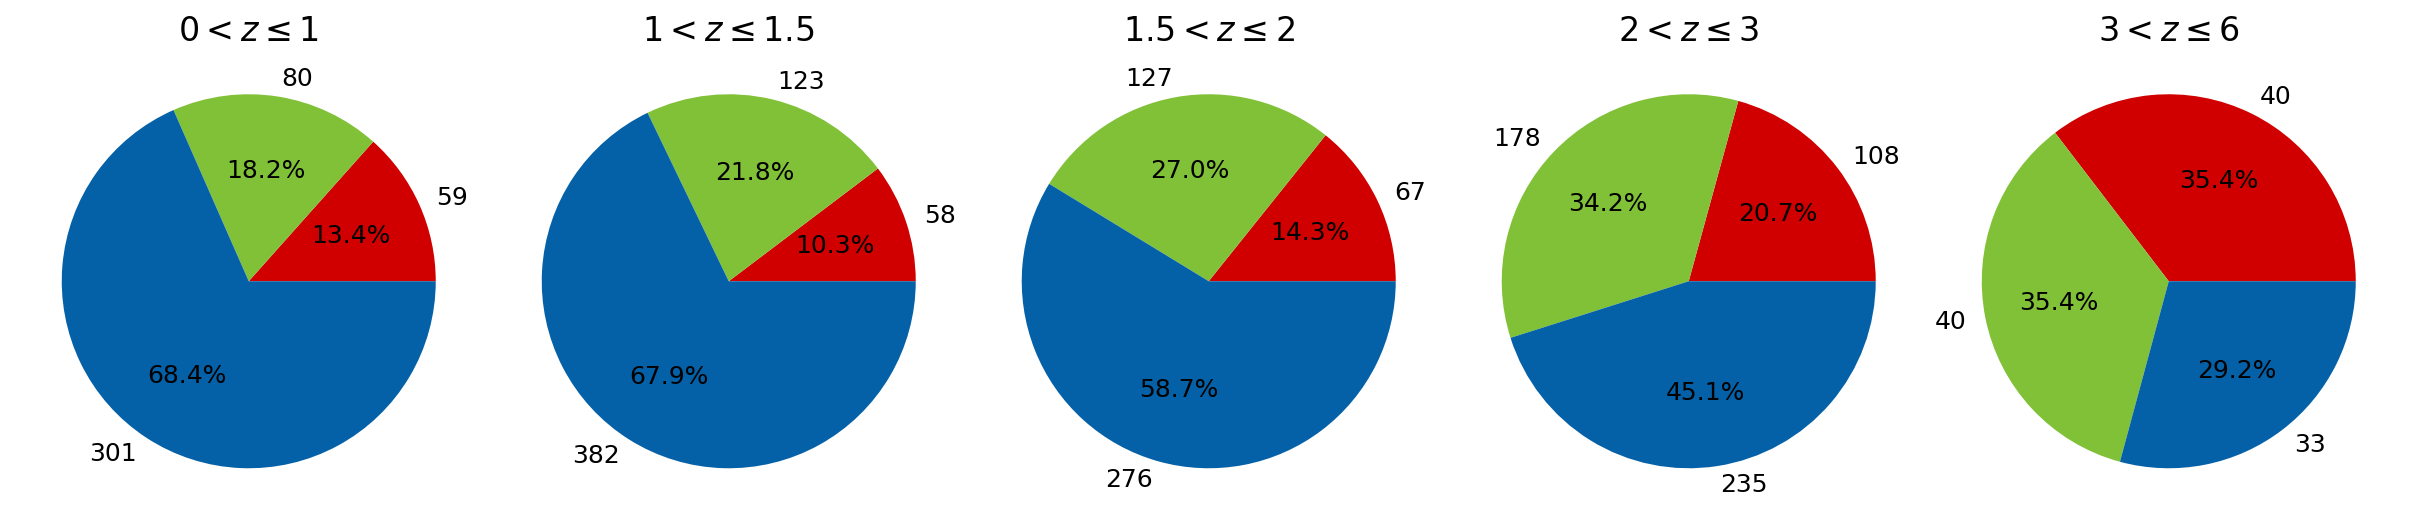

In [10]:
def TriPie_ax(ax,red,grn,blu,title=''):
    # plot pie chart on axis
    ax.pie( [red,grn,blu], 
            labels=[red,grn,blu], 
            colors=[adp.c_ir, adp.c_ir_xray, adp.c_xray],
            autopct='%1.1f%%',
            textprops={'fontsize': adp.MID}
        )
    if(title):
        ax.set_title(title, pad=0)
   
def TriPie_byZ(triID_allZ, save=''):
    fig, ax = adp.ByZ_SetupFig(
        n = len(tri_byZ.keys()),
        orientVertical=False
    )
    
    # make plot for each redshift range
    i = 0
    for zrange,color in tri_byZ.items() :
        # plot on axis 
        TriPie_ax(
            ax[i],
            color['RED']['ID'].size,
            color['GRN']['ID'].size,
            color['BLU']['ID'].size,
            zrange
        )
        # increment plot
        i+=1
    adp.ByZ_FinishPlot(fig)

TriPie_byZ(triID_allZ, adp.path_fig + '//v2_piechart_tri_zPanels.png')

In [11]:
def TriToIRACcolors(
    id_agn,
    id_catalog,
    ch1,    # f_3.6um
    ch2,    # f_4.5 um
    ch3,    # f_5.6um
    ch4     # f_8.0um
):
    # match IDs to data20 
    onCat, onAGN = match.match(id_catalog, id_agn)
    # calculate colors 
    x = adp.IRACx(ch1[onCat], ch3[onCat])
    y = adp.IRACy(ch2[onCat], ch4[onCat]) 
    # return dictionary of IRAC colors by AGN group
    return(x,y)

# calculate IRAC colors for all agn
for keyRange, dataColor in tri_byZ.items() : 
    for keyColor, dataDict in dataColor.items() : # Im sure there is a faster way to do this... O(n^2)
        x,y = TriToIRACcolors(
            dataDict['ID'],
            id_data20,
            ch1_data20,ch2_data20,ch3_data20,ch4_data20 
        )
        dataDict['x'] = x
        dataDict['y'] = y

In [12]:
def PlotTricolor_ax(
    ax,
    x_red, y_red,
    x_grn, y_grn,
    x_blu, y_blu,
    fullText='', z_min=-1, z_max=-1,  greaterEqual=False, lessEqual=True,
):
    # plot data
    ax.scatter(x_blu, y_blu, marker='s', c=adp.c_xray,     s=3, label='Exclusive X-ray (n='+str(len(x_blu))+')')
    ax.scatter(x_red, y_red, marker='^', c=adp.c_ir,       s=3, label='Exclusive MIR (n='+  str(len(x_red))+')')
    ax.scatter(x_grn, y_grn, marker='o', c=adp.c_ir_xray,  s=3, label='Inclusive (n='+      str(len(x_grn))+')')
    # decorations
    adp.PlotDonleyWedge_ax(ax)
    adp.AddText_n_ax(ax,len(x_blu)+len(x_red)+len(x_grn), pre='$\mathrm{N_{total}}$ = ')
    adp.AddText_z_ax(ax, fullText, z_min, z_max,  greaterEqual, lessEqual)
    # axis settings
    ax.set_aspect('equal')
    ax.set_adjustable('box') 
    ax.set_xlim([-0.7,1.0])
    ax.set_ylim([-0.7,1.0])
    ax.set_xticks([-0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticks([-0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))



In [13]:
def PlotTricolor_byZ(
        tri_byZ, 
        save='',
        orientVertical=True
) : 
    fig, ax = adp.ByZ_SetupFig(
        n = len(tri_byZ.keys()),
        orientVertical = orientVertical
    )
    # make plot for each redshift range
    i = 0
    for zrange,color in tri_byZ.items() :
        # plot on axis 
        PlotTricolor_ax(
            ax[i],
            color['RED']['x'], color['RED']['y'], 
            color['GRN']['x'], color['GRN']['y'], 
            color['BLU']['x'], color['BLU']['y'], 
            zrange
        )
        # increment plot
        i+=1
    if(orientVertical):
        xpos=(0.5, -0.01)
        ypos=(0.15,  0.5)
    else:
        xpos=(0.5, 0.18)
        ypos=(-0.02,  0.5)
    adp.ByZ_FinishPlot(
        fig,
        '$\log(f_{5.8um}/f_{3.6um})$',
        '$\log(f_{8.0um}/f_{4.5um})$',
        save, xpos, ypos
    )

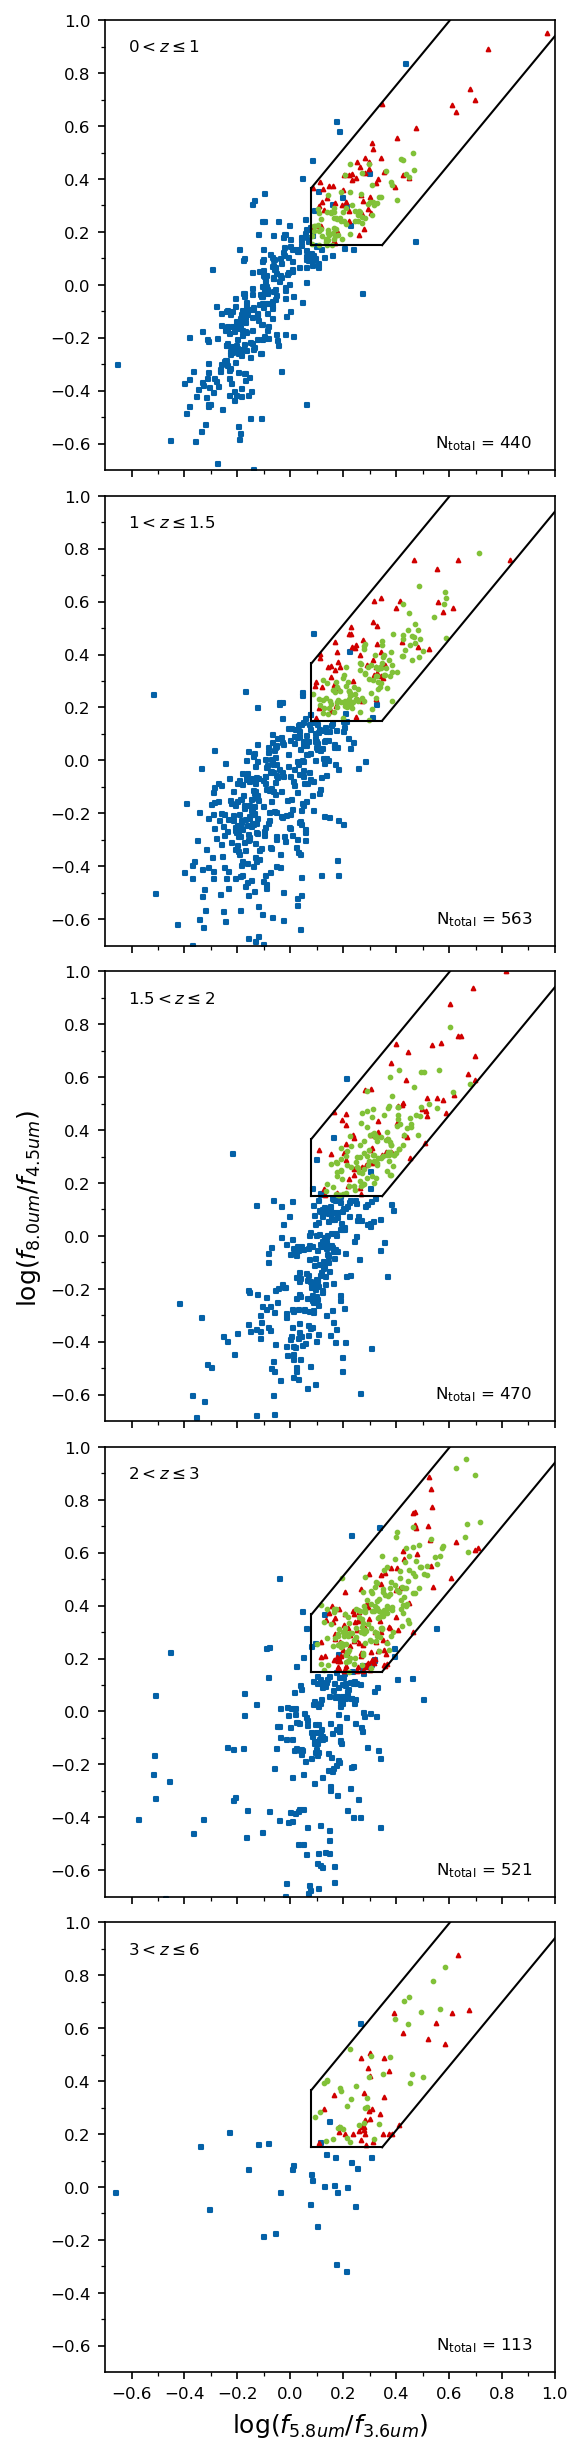

In [14]:
PlotTricolor_byZ(
    tri_byZ,
    save = adp.path_fig + '//v2_colorDiagram_tri_zPanels_tall.png',
    orientVertical=True
)

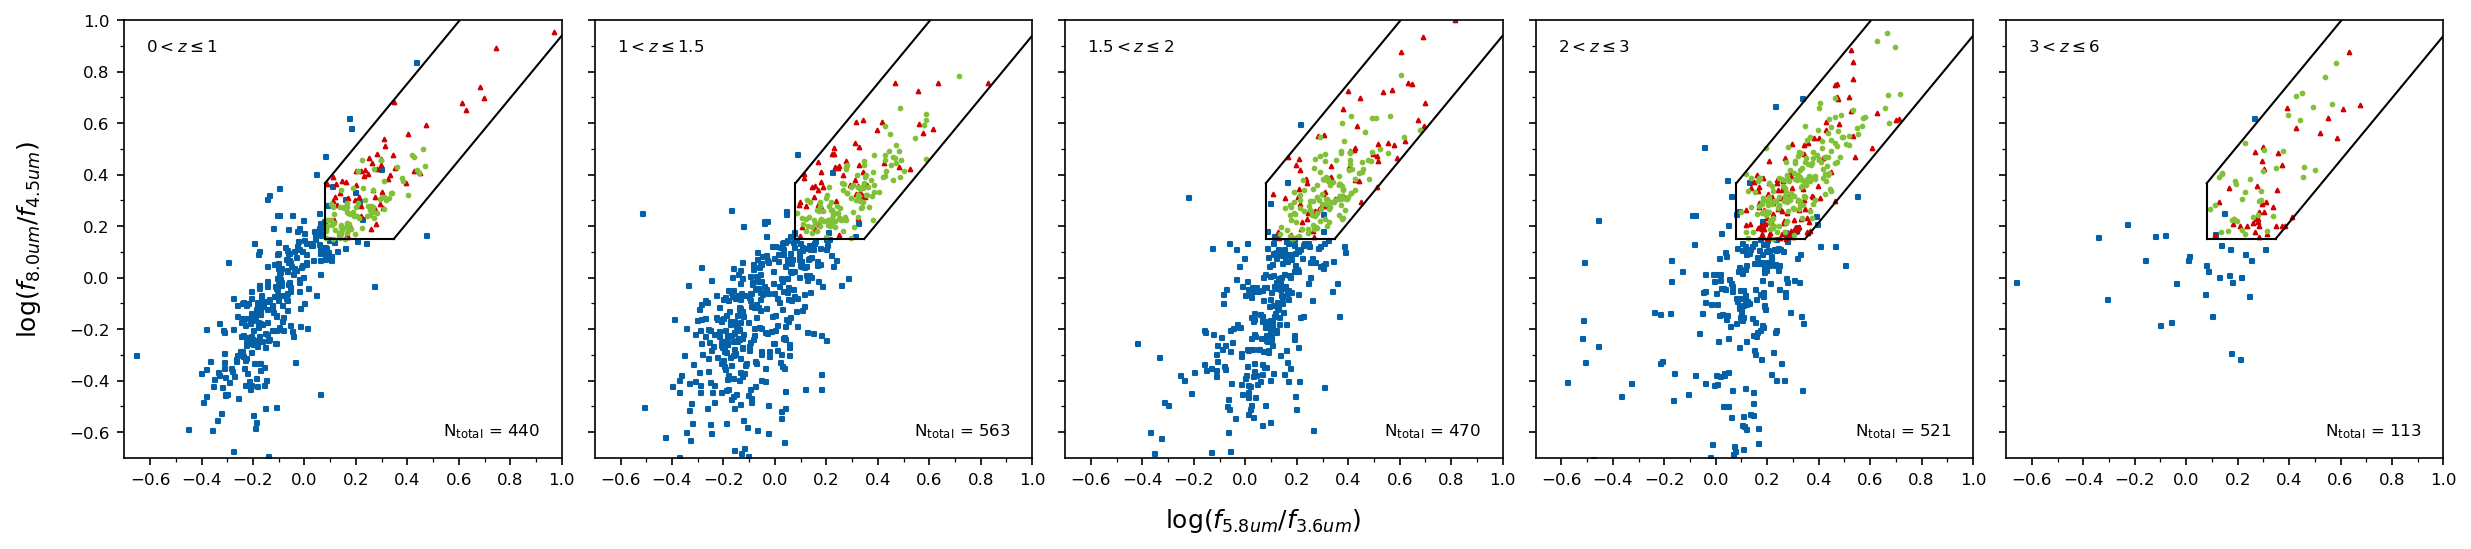

In [15]:

PlotTricolor_byZ(
    tri_byZ,
    save = adp.path_fig + '//v2_colorDiagram_tri_zPanels_wide.png',
    orientVertical=False
)

# X-ray

In [16]:
def GetXrayFromAGNDuo(
    agnIDs_dict,
    id_data16,
    L0510_data16,
    k0510_data16,
    printInfo=True
):
    # merge AGN lists into one
    agnIDs_full = np.unique(np.concatenate((agnIDs_dict['MIR'],agnIDs_dict['XRAY'])))
    
    ### get AGN with a good Lx 

    # get key to the IDs from C-COSMOS data, which are parallel to Xray data
    key_agnID, key_id = match.match(agnIDs_full, id_data16)

    # get xray luminosity data
    Lx_agn = adp.IntrinsicLuminosity(L0510_data16[key_id], k0510_data16[key_id])
    mask_Lx_agn_good = Lx_agn > 0     

    # make dict containing ID and Lx
    agnLx_dict = {
        'ID' : agnIDs_full[(key_agnID[mask_Lx_agn_good])], # key_agnID and key_id are the same size and order
        'Lx' : Lx_agn[mask_Lx_agn_good]
    }

    ### get remaining AGN 

    # match all agn to those with Lx
    key_fullLx, key_Lx = match.match(agnIDs_full, agnLx_dict['ID'])

    # get AGN without Lx
    mask_noLx = np.ones(agnIDs_full.shape, dtype=bool)
    mask_noLx[key_fullLx] = False 
    agn_noLx = { 'ID' : agnIDs_full[mask_noLx] }

    # print info 
    if(printInfo):
        print('Number of AGN with Lx detection:\t', len(agnLx_dict['ID']))
        print('Number of AGN without Lx detection:\t', len(agn_noLx['ID']))
        print('Number of all AGN :\t\t\t', len(agnLx_dict['ID'])+len(agn_noLx['ID']))

    # return agn with and without Lx
    return(agnLx_dict, agn_noLx)

# get AGN with Luminosity
agn_yLx, agn_nLx =  GetXrayFromAGNDuo(
    agnIDs,
    id_data16,
    L0510_data16,
    k0510_data16
)

Number of AGN with Lx detection:	 1795
Number of AGN without Lx detection:	 312
Number of all AGN :			 2107


In [17]:
def IDtoIRACcolors(
    id_agn,
    id_catalog,
    ch1,    # f_3.6um
    ch2,    # f_4.5 um
    ch3,    # f_5.6um
    ch4     # f_8.0um
):
    # match IDs to get IRAC channels 
    key_cat, key_agn = match.match(id_catalog, id_agn)
    # calculate colors
    x = adp.IRACx(ch1[key_cat], ch3[key_cat]),
    y = adp.IRACy(ch2[key_cat], ch4[key_cat])
    return(x, y)

# get colors 
x,y= IDtoIRACcolors(
    agn_yLx['ID'],
    id_data20,ch1_data20,ch2_data20,ch3_data20,ch4_data20 
)
agn_yLx['x'] = x
agn_yLx['y'] = y


x,y = IDtoIRACcolors(
    agn_nLx['ID'],
    id_data20,ch1_data20,ch2_data20,ch3_data20,ch4_data20 
)
agn_nLx['x'] = x
agn_nLx['y'] = y

In [18]:
def GetAGNinZrange(agnDict, zDict_split, printLengths=True):
    agnByZ = {}
    # for each redshft range 
    for key,zdata in zDict_split.items() :
        # match IDs
        onAGN, onZ = match.match(agnDict['ID'], zdata['ID'])
        # setup dict entry 
        agnByZ[key] = {}
        agnByZ[key]['z'] = zdata['z'][onZ]
        # get data
        for agnkey, agndata in agnDict.items() :
            if(isinstance(agndata, tuple)):
                agnByZ[key][agnkey] = agndata[0][onAGN] 
            else: 
                agnByZ[key][agnkey] = agndata[onAGN]
        # print
        if(printLengths) :
            print(key, ': ', len(agnByZ[key]['z']))
    return(agnByZ)

agn_yLx_byZ = GetAGNinZrange(agn_yLx, zDict_split)
print('~~~')
agn_nLx_byZ = GetAGNinZrange(agn_nLx, zDict_split)

$0 < z \leq 1$ :  401
$1 < z \leq 1.5$ :  505
$1.5 < z \leq 2$ :  403
$2 < z \leq 3$ :  413
$3 < z \leq 6$ :  73
~~~
$0 < z \leq 1$ :  39
$1 < z \leq 1.5$ :  58
$1.5 < z \leq 2$ :  67
$2 < z \leq 3$ :  108
$3 < z \leq 6$ :  40


In [19]:
# plot AGN w/ and w/o Xrays on Donley IRAC color-color plot with X-ray luminosity colorbar
def PlotDonleyXray_ax(
    ax,                     # figure axis 
    x_nX, y_nX,             # no X-ray detections 
    x_yX, y_yX,             # yes X-ray detections
    Lx,                     # X-ray luminosity (colorbar)
    vmin=41.5, vmax=46.0,   # colorbar range 
    printInfo=True,         # output text
    showCrosses=True,       # show no X-ray detection swhen true
    fullText='', z_min=-1, z_max=-1,  greaterEqual=False, lessEqual=True,
):
    # plot data 
    if(showCrosses) :
        ax.scatter(x_nX, y_nX, marker='x', s=4, c='lightgrey', label='X-ray undetected (n='+str(len(x_nX))+')')
    ax.scatter(x_yX, y_yX, marker='D', s=3, c=Lx, cmap=plt.cm.get_cmap('inferno',9), vmin=vmin, vmax=vmax,  label='X-ray detected (n='+str(len(x_yX))+')')   
    # decorations
    adp.PlotDonleyWedge_ax(ax)
    adp.AddText_z_ax(ax, fullText, z_min, z_max,  greaterEqual, lessEqual)
    if(showCrosses):
        adp.AddText_n_ax(ax,len(x_nX)+len(x_yX), pre='$\mathrm{N_{total}}$ = ')
    else:
        adp.AddText_n_ax(ax,len(x_yX))
    # axis settings
    ax.set_aspect('equal')
    ax.set_adjustable('box') 
    ax.set_xlim([-0.7,1.0])
    ax.set_ylim([-0.7,1.0])
    ax.set_xticks([-0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticks([-0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))

    #print info 
    if(printInfo) : 
        print('Number with Xray:\t',    len(x_yX))
        print('Number without Xray:\t', len(x_nX))
        print('Total Number:\t\t',      len(x_yX)+len(x_nX))

In [20]:
def PlotDonleyXray_byZ(
        agn_yLx_byZ, 
        agn_nLx_byZ, 
        save='',
        orientVertical=True
):
    n = len(tri_byZ.keys())
    fig, ax = adp.ByZ_SetupFig(
        n=n,
        orientVertical=orientVertical
    )
    # make plot for each redshift range
    i = 0
    for zrange in agn_yLx_byZ.keys() :  
        print(zrange)          
        # plot on axis 
        PlotDonleyXray_ax(
            ax[i],
            agn_nLx_byZ[zrange]['x'], agn_nLx_byZ[zrange]['y'],
            agn_yLx_byZ[zrange]['x'], agn_yLx_byZ[zrange]['y'],
            agn_yLx_byZ[zrange]['Lx'],
            fullText=zrange,
        )
        print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
        # increment plot
        i+=1

    if(orientVertical):
        cbarAx = 0
        cbarLocation = 'top'
        xpos=(0.5, -0.01)
        ypos=(0.15,  0.5)
        
    else:
        cbarAx = n-1
        cbarLocation = 'right'
        xpos=(0.5, 0.18)
        ypos=(-0.02,  0.5)

    SED.PlotColorbar_ax(
            ax=ax[cbarAx], 
            cmap=plt.cm.get_cmap('inferno',9), 
            min=41.5, 
            max=46.0, 
            n_ticks=10, 
            label='$\log( \; L_{x(0.5-10keV)} \; [erg \; s^{-1}] \;)$',
            location=cbarLocation,
            extend='neither',
            shrink=0.48
        )

    adp.ByZ_FinishPlot(
        fig,
        '$\log(f_{5.8um}/f_{3.6um})$',
        '$\log(f_{8.0um}/f_{4.5um})$',
        save, xpos, ypos
    )


$0 < z \leq 1$
Number with Xray:	 401
Number without Xray:	 39
Total Number:		 440
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
$1 < z \leq 1.5$
Number with Xray:	 505
Number without Xray:	 58
Total Number:		 563
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
$1.5 < z \leq 2$
Number with Xray:	 403
Number without Xray:	 67
Total Number:		 470
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
$2 < z \leq 3$
Number with Xray:	 413
Number without Xray:	 108
Total Number:		 521
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
$3 < z \leq 6$
Number with Xray:	 73
Number without Xray:	 40
Total Number:		 113
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


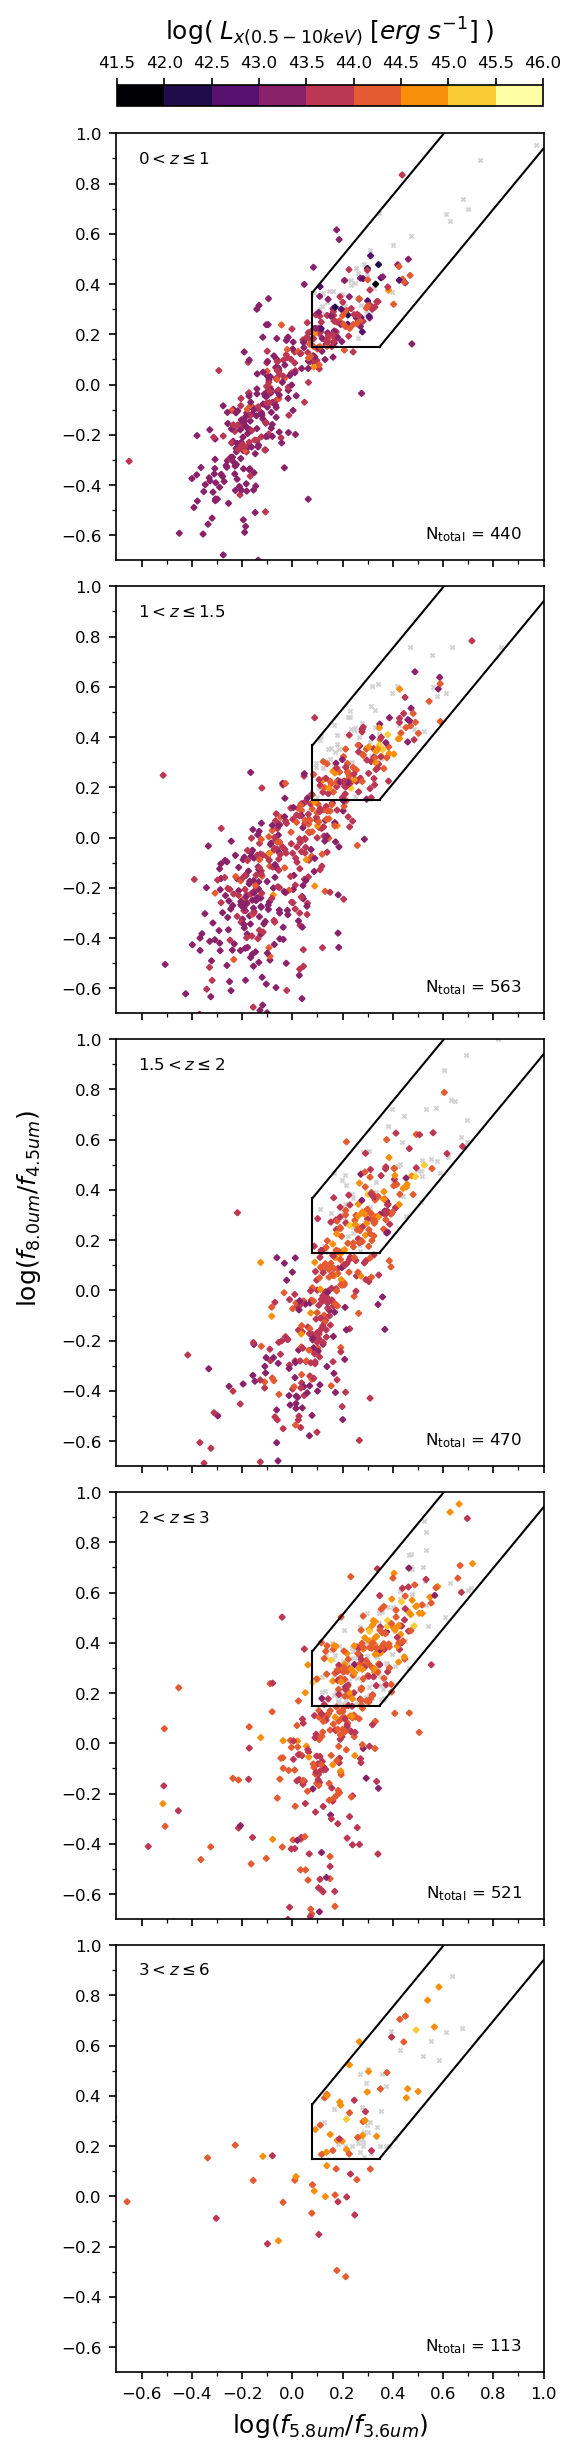

In [21]:
PlotDonleyXray_byZ(agn_yLx_byZ, agn_nLx_byZ, save=adp.path_fig+'\\v2_colorDiagram_Lx_zPanels_tall.png',orientVertical=True)

$0 < z \leq 1$
Number with Xray:	 401
Number without Xray:	 39
Total Number:		 440
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
$1 < z \leq 1.5$
Number with Xray:	 505
Number without Xray:	 58
Total Number:		 563
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
$1.5 < z \leq 2$
Number with Xray:	 403
Number without Xray:	 67
Total Number:		 470
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
$2 < z \leq 3$
Number with Xray:	 413
Number without Xray:	 108
Total Number:		 521
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
$3 < z \leq 6$
Number with Xray:	 73
Number without Xray:	 40
Total Number:		 113
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


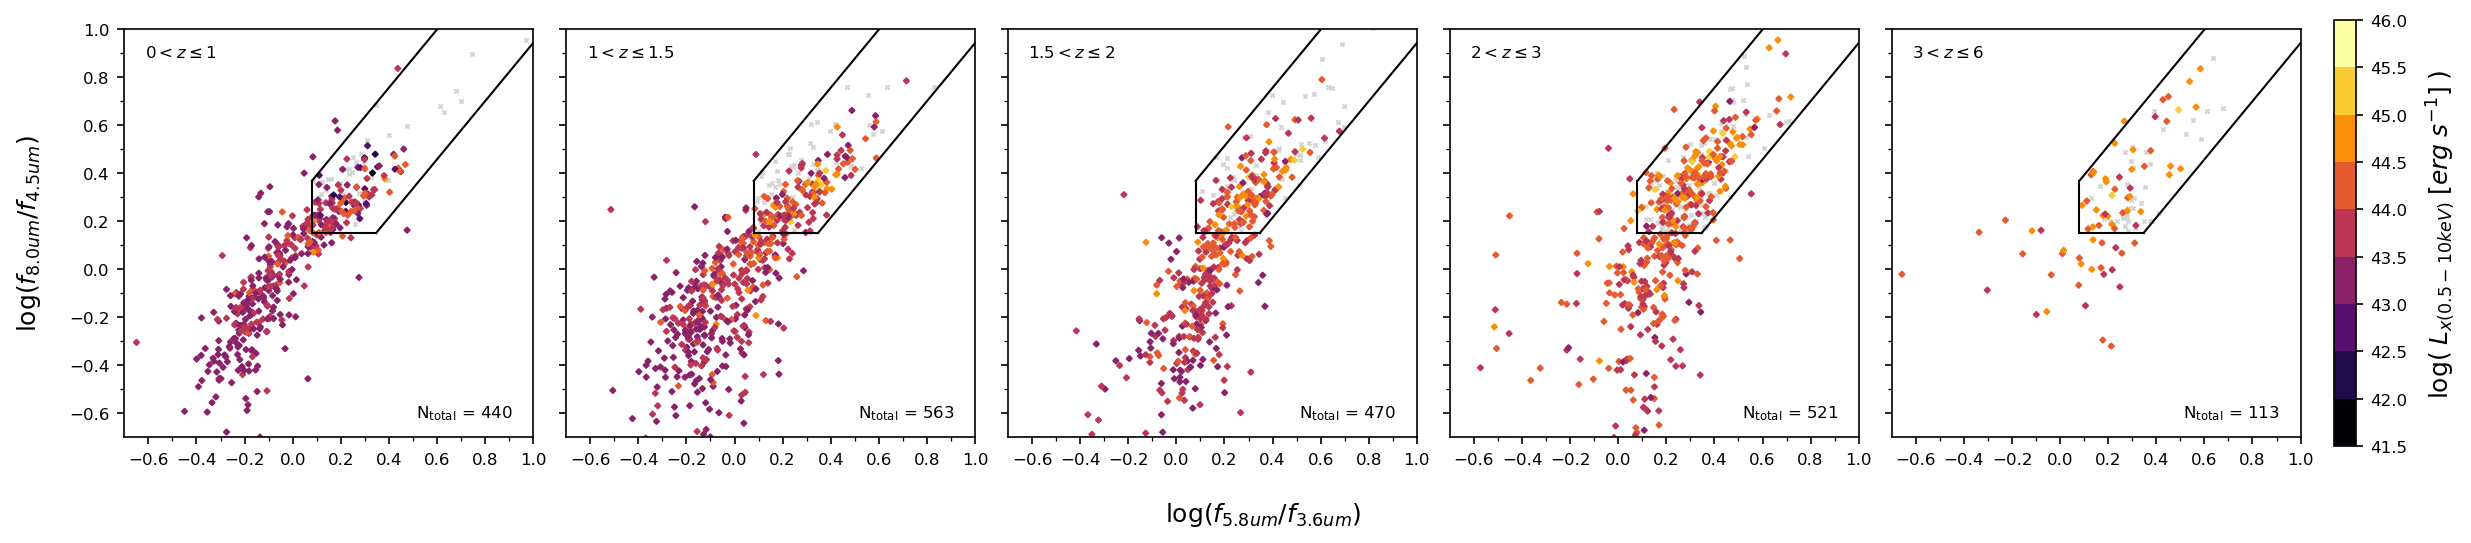

In [22]:
PlotDonleyXray_byZ(agn_yLx_byZ, agn_nLx_byZ, save=adp.path_fig+'\\v2_colorDiagram_Lx_zPanels_wide.png',orientVertical=False)

# Histogram 

In [23]:
def AddXrayDetectedByDonley(agn_yLx_byZ, DonleyIDs):
    # for each redshift range in dict
    for dataDict in agn_yLx_byZ.values():
        # get indicies of Donley selected AGN
        onData, onIDs = match.match(dataDict['ID'], DonleyIDs)
        # build boolean array that is true for IDs that are Donley selected
        areDonleySelected = np.zeros( len(dataDict['ID']), dtype=bool)
        areDonleySelected[onData] = True
        # add to dictionary 
        dataDict['Donley Selected'] = areDonleySelected

AddXrayDetectedByDonley(
    agn_yLx_byZ, 
    np.concatenate( (triID_allZ['RED'], triID_allZ['GRN']))
    )

In [27]:
def PlotXrayHistogram_Dual_ax(
    ax,             # axis 
    x1,             # Lx NOT Donley selected 
    x2,             # Lx Donley selected 
    c1=adp.c_xray,  # blue
    c2='#DC6204',   # orange
    h=140,          # plot height 
    bins=np.arange(42,46,0.25), # histogram bins
    printInfo=True, # print information when true
    fullText='', z_min=-1, z_max=-1,  greaterEqual=False, lessEqual=True, # z text stuff
) :
    # get full sample 
    x = np.concatenate((x1,x2))
    # Plot histogramS
    ax.hist(x , bins=bins, histtype='bar',  color='lightgray', linewidth=2)
    ax.hist(x2, bins=bins, histtype='step', edgecolor=c2,      linewidth=2)
    ax.hist(x1, bins=bins, histtype='step', edgecolor=c1,      linewidth=2)
    # plot settings
    ax.set_ylim(ymin=0, ymax=h)
    ax.xaxis.set_minor_locator(AutoMinorLocator(4))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    adp.AddText_n_ax(ax,len(x1)+len(x2), pre='$\mathrm{N_{total}}$ = ')
    adp.AddText_z_ax(ax, fullText, z_min, z_max,  greaterEqual, lessEqual)
    adp.MeanLineForHist_ax(ax=ax,x=x1,c=c1,xtext=0.998,ytext=0.94,horizAlign='right',pre='')
    adp.MeanLineForHist_ax(ax=ax,x=x2,c=c2,xtext=1.002,ytext=0.94,horizAlign='left' ,pre='')
    # print info
    if(printInfo) :
        print('Dont meet Donley criterea (blue):\t', len(x1))
        print('Meet Donley criterea (orange):\t\t', len(x2))
        print('Total AGN:\t', len(x1)+len(x2))
        print('Min Lx:\t', np.min(x))
        print('Max Lx:\t', np.max(x))


In [28]:
def PlotXrayHistogram_Dual_byZ(
        agn_yLx_byZ, 
        save='',
        orientVertical=True
):
    if(orientVertical):
        figsizeConstVal=6
        xpos=(0.5, -0.01)
        ypos=(-0.05,  0.5)
    else:
        xpos=(0.5, -0.08)
        ypos=(-0.01,  0.5)
        figsizeConstVal=3

    fig, ax = adp.ByZ_SetupFig(
        n = len(agn_yLx_byZ.keys()),
        orientVertical=orientVertical,
        figsizeConstVal=figsizeConstVal
    )
    # make plot for each redshift range
    i = 0
    for zrange, dataDict in agn_yLx_byZ.items() :  
        print(zrange)       
        donleySelectedArr = dataDict['Donley Selected']
        x1 = dataDict['Lx'][~donleySelectedArr]
        x2 = dataDict['Lx'][donleySelectedArr]
        # plot on axis 
        PlotXrayHistogram_Dual_ax(
            ax[i],x1,x2,fullText=zrange
        )
        print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
        # increment plot
        i+=1
    adp.ByZ_FinishPlot(
        fig,
        '$\log( \; L_{x(0.5-10keV)} \; [erg \; s^{-1}] \;)$',
        'Number',
        save, xpos, ypos
    )

$0 < z \leq 1$
Dont meet Donley criterea (blue):	 301
Meet Donley criterea (orange):		 100
Total AGN:	 401
Min Lx:	 41.887001037597656
Max Lx:	 44.66400146484375
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
$1 < z \leq 1.5$
Dont meet Donley criterea (blue):	 382
Meet Donley criterea (orange):		 123
Total AGN:	 505
Min Lx:	 43.00026321411133
Max Lx:	 45.27000045776367
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
$1.5 < z \leq 2$
Dont meet Donley criterea (blue):	 276
Meet Donley criterea (orange):		 127
Total AGN:	 403
Min Lx:	 43.03300094604492
Max Lx:	 45.327999114990234
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
$2 < z \leq 3$
Dont meet Donley criterea (blue):	 235
Meet Donley criterea (orange):		 178
Total AGN:	 413
Min Lx:	 43.2599983215332
Max Lx:	 45.41007614135742
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
$3 < z \leq 6$
Dont meet Donley criterea (blue):	 33
Meet Donley criterea (orange):		 40
Total AGN:	 73
Min Lx:	 43.73099899291992
Max Lx:	 45.085296630859375
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


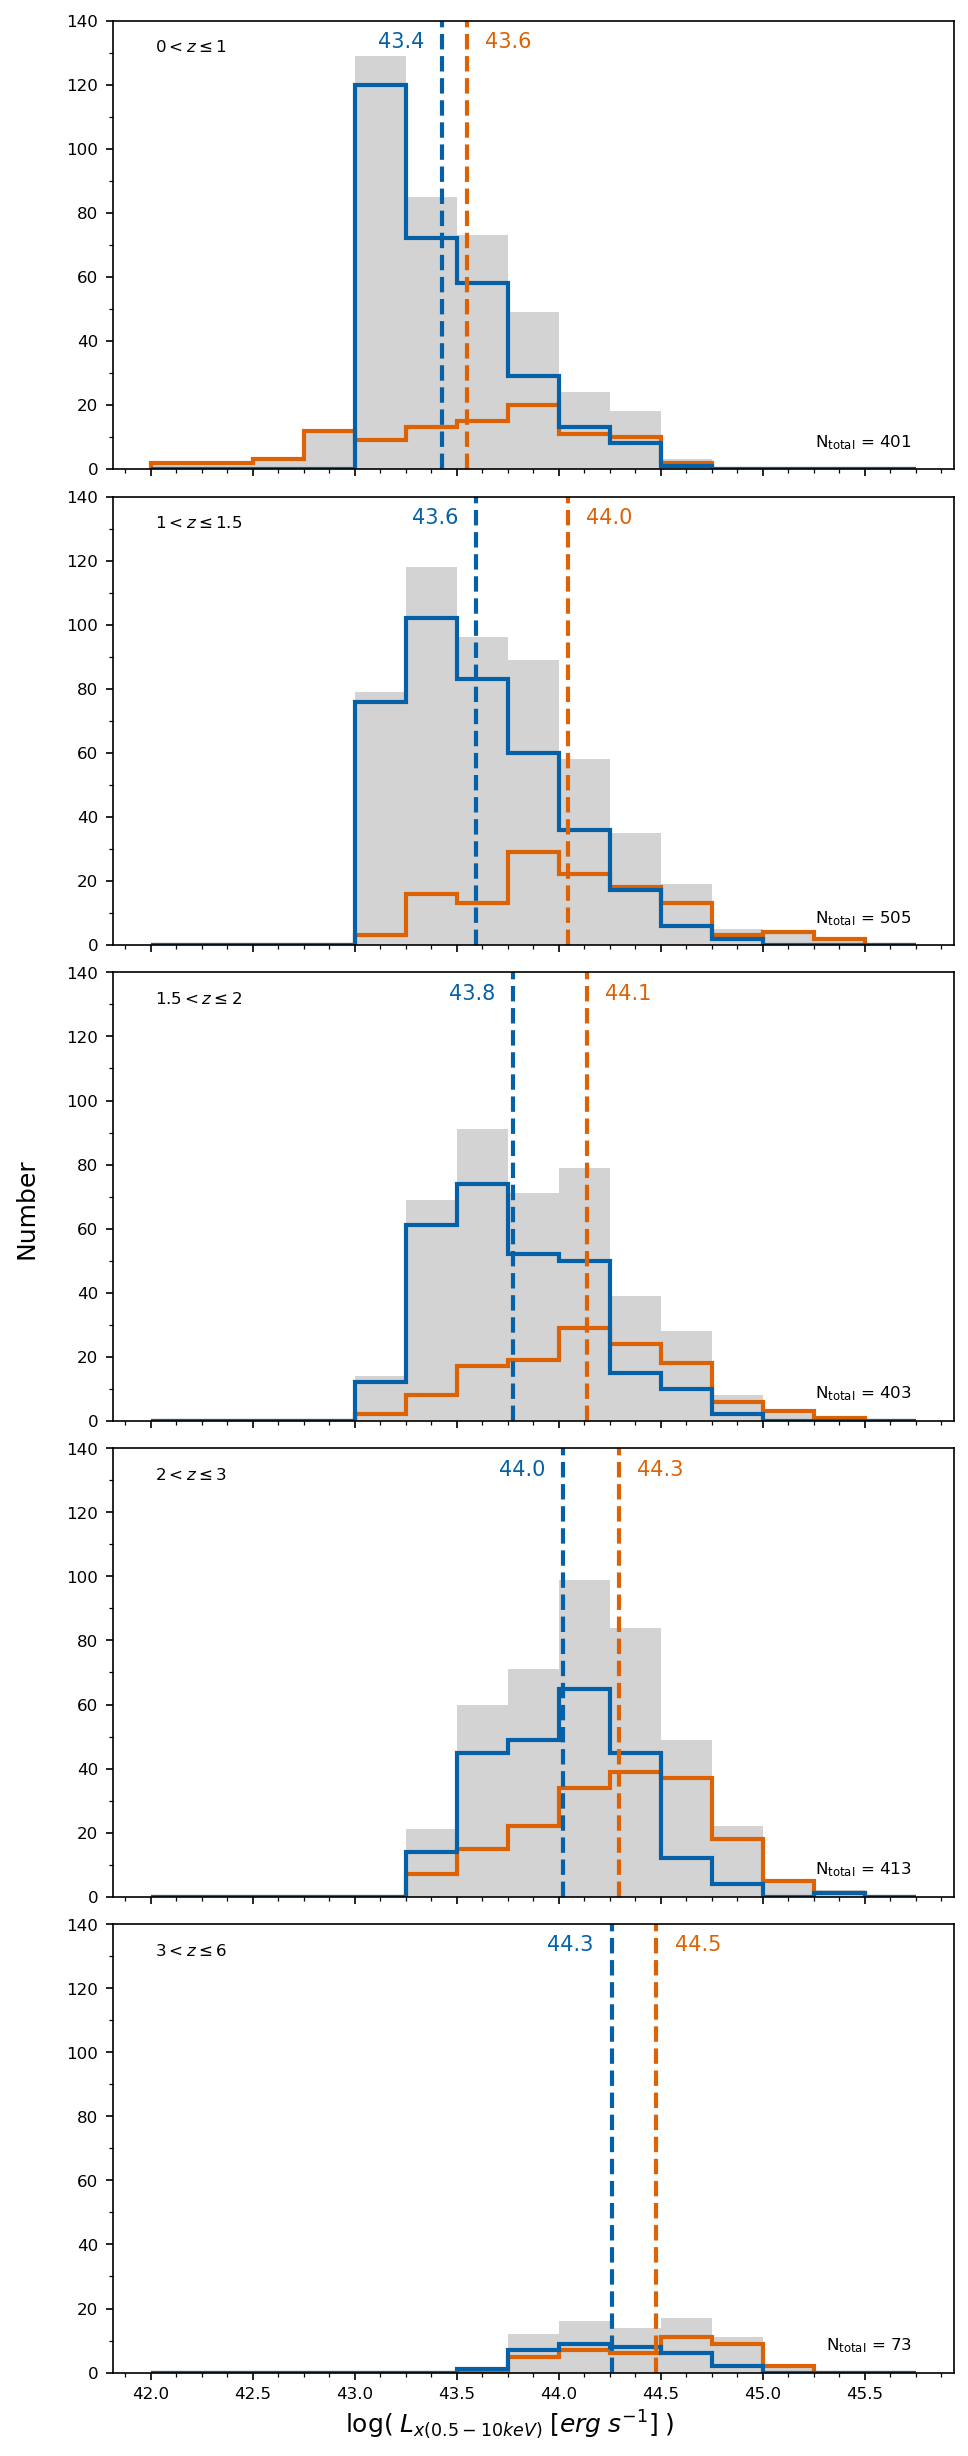

In [29]:
PlotXrayHistogram_Dual_byZ(agn_yLx_byZ,adp.path_fig+'\\v2_LxHist_isDonley_zPanels_tall.png',orientVertical=True)

$0 < z \leq 1$
Dont meet Donley criterea (blue):	 301
Meet Donley criterea (orange):		 100
Total AGN:	 401
Min Lx:	 41.887001037597656
Max Lx:	 44.66400146484375
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
$1 < z \leq 1.5$
Dont meet Donley criterea (blue):	 382
Meet Donley criterea (orange):		 123
Total AGN:	 505
Min Lx:	 43.00026321411133
Max Lx:	 45.27000045776367
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
$1.5 < z \leq 2$
Dont meet Donley criterea (blue):	 276
Meet Donley criterea (orange):		 127
Total AGN:	 403
Min Lx:	 43.03300094604492
Max Lx:	 45.327999114990234
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
$2 < z \leq 3$
Dont meet Donley criterea (blue):	 235
Meet Donley criterea (orange):		 178
Total AGN:	 413
Min Lx:	 43.2599983215332
Max Lx:	 45.41007614135742
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
$3 < z \leq 6$
Dont meet Donley criterea (blue):	 33
Meet Donley criterea (orange):		 40
Total AGN:	 73
Min Lx:	 43.73099899291992
Max Lx:	 45.085296630859375
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


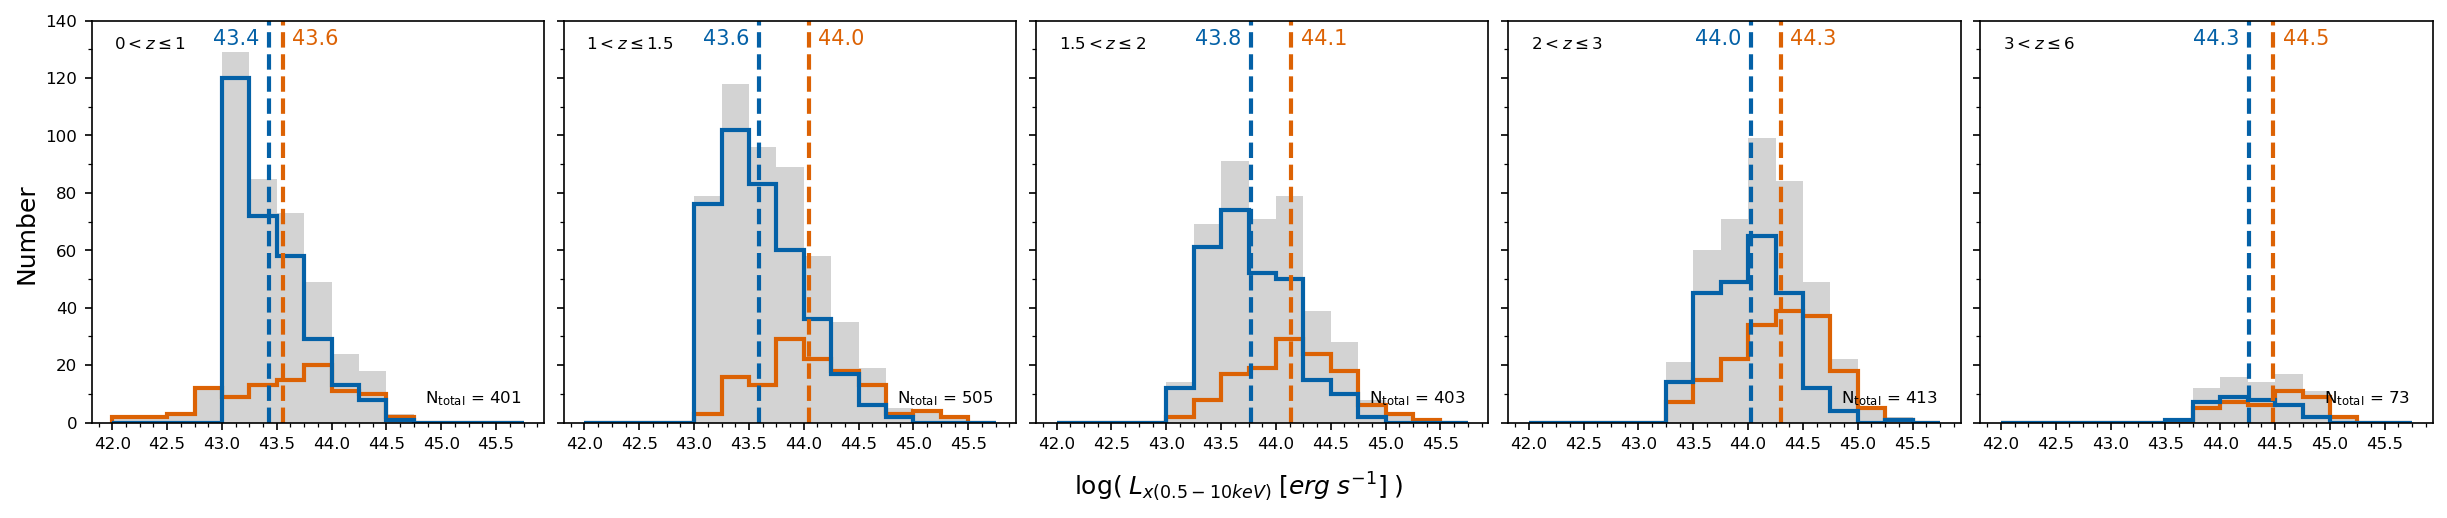

In [30]:
PlotXrayHistogram_Dual_byZ(agn_yLx_byZ,adp.path_fig+'\\v2_LxHist_isDonley_zPanels_wide.png',orientVertical=False)